## Importing Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler  
from darts.models import XGBModel
from bayes_opt import BayesianOptimization
import logging
logging.getLogger("cmdstanpy").setLevel(logging.WARNING)

F:\Anaconda\envs\MLProjects\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Reading and Preparing the Data

In [3]:
df = pd.read_csv("../data/Sunspots.csv")
df.drop(columns = ['Unnamed: 0'],inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df_idx = df.set_index(['Date'],drop=False)

In [4]:
act_series_2010 = TimeSeries.from_dataframe(df_idx[:'2009'], 'Date', 'Monthly Mean Total Sunspot Number')  
act_series_2000 = TimeSeries.from_dataframe(df_idx[:'1999'], 'Date', 'Monthly Mean Total Sunspot Number')  
act_series_1990 = TimeSeries.from_dataframe(df_idx[:'1989'], 'Date', 'Monthly Mean Total Sunspot Number')  

## XGBoost Model

In [5]:
lags = []
for i in range(1,20):
    lags.append(i*-12*9)  
    lags.append(i*-6*10)  
    lags.append(i*-12*11)  
lags.extend([-1,-2])

def model_xgboost(series, length, params):
    def encode_year(idx):
        return idx.year

    add_encoders = {
        'transformer': Scaler(),
        'tz': 'CET',
    }
    
    xgb_model = XGBModel(
        lags =lags,
        random_state = 42,
        add_encoders = add_encoders,
        max_depth = params['max_depth'],
        learning_rate = params['learning_rate'],
        subsample = params['subsample'],
        colsample_bytree = params['colsample_bytree'],
        colsample_bylevel = params['colsample_bylevel'],
        colsample_bynode = params['colsample_bynode'],
        gamma = params['gamma'],
        min_child_weight = params['min_child_weight'],
        reg_alpha = params['reg_alpha'],
        reg_lambda = params['reg_lambda']
    )

    xgb_model.fit(series)
    pred_series = xgb_model.predict(length)
    df_pred = TimeSeries.to_dataframe(pred_series).reset_index()
    df_pred.columns = ['Date','Monthly Mean Sunspot Predicted']
    df_pred = df_pred.set_index(['Date'],drop=False)
    
    return df_pred

In [6]:
#Combining the Predicted and Actual Values and Evaluating our Model
def model_mean_error(df_pred):
    df_pred['Month'] = df_pred['Date'].dt.to_period('M')
    df_idx['Month'] = df_idx['Date'].dt.to_period('M')
    df_pred = df_pred.merge(df_idx,on='Month',how='inner')
    df_pred.rename(columns = {'Date_y':'Date','Monthly Mean Total Sunspot Number':'Monthly Mean Sunspot Actual'},inplace=True)
    df_pred['mae'] = abs(df_pred['Monthly Mean Sunspot Predicted'] - df_pred['Monthly Mean Sunspot Actual'])
    return df_pred['mae'].mean()

In [7]:
#Visualizing out forecasting along with the actual values
def viz_forecast(df_pred):
    plt.figure(figsize=[12,4])
    plt.plot(df_idx['1960':].index,df_idx['1960':]['Monthly Mean Total Sunspot Number'],label='Actual',color='steelblue')
    plt.plot(df_pred['Date'],df_pred['Monthly Mean Sunspot Predicted'],label='Predicted',color='#FF6347')
    #plt.plot(df_pred['Date'],df_pred['Monthly Mean Sunspot Actual'],label='Actual',color='r')
    
    plt.xlabel('Date')
    plt.ylabel('Monthly Mean Sunspots')
    plt.gca().xaxis.set_major_locator(mdates.YearLocator(5))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.title('Predicted vs Actual Monthly Mean Sunspots')
    plt.legend()
    plt.xticks(rotation=90)
    
    plt.tight_layout()
    plt.show()

## Optimizing the Parameters for the Model

In [198]:
def optimize_model(max_depth,learning_rate,subsample,colsample_bytree,colsample_bylevel,colsample_bynode,gamma,min_child_weight,reg_alpha,reg_lambda):
    
    params = {
        'max_depth': int(max_depth),
        'learning_rate': round(learning_rate,2),
        'subsample': round(subsample, 2),
        'colsample_bytree': round(colsample_bytree, 2),
        'colsample_bylevel': round(colsample_bylevel, 2),
        'colsample_bynode': round(colsample_bynode, 2),
        'gamma': round(gamma, 2),
        'min_child_weight': int(min_child_weight),
        'reg_alpha': round(reg_alpha, 2),
        'reg_lambda': round(reg_lambda, 2)
    }
    forecast_df = model_xgboost(act_series_1990,len(df_idx['1990':'2004']),params)
    return model_mean_error(forecast_df)*-1

In [211]:
param_space = {
    'max_depth': (3,7),
    'learning_rate': (0.01,0.3),
    'subsample': (0.5,1),
    'colsample_bytree': (0.5,1),
    'colsample_bylevel': (0.5,1),
    'colsample_bynode': (0.5,1),
    'gamma': (0,5),
    'min_child_weight': (1,10),
    'reg_alpha': (0,1),
    'reg_lambda': (0,1)
}

optimizer = BayesianOptimization(
    f=optimize_model,
    pbounds=param_space,
)

optimizer.maximize(
    init_points=10,
    n_iter=10        # Number of iterations to perform
)

print(optimizer.max)

|   iter    |  target   | colsam... | colsam... | colsam... |   gamma   | learni... | max_depth | min_ch... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------------------
| 1         | -40.82    | 0.6059    | 0.6061    | 0.6743    | 1.525     | 0.1759    | 6.681     | 9.393     | 0.08549   | 0.1816    | 0.7363    |
| 2         | -57.19    | 0.9866    | 0.5621    | 0.7652    | 0.6938    | 0.09822   | 3.595     | 4.666     | 0.8814    | 0.3054    | 0.8682    |
| 3         | -51.91    | 0.7564    | 0.6083    | 0.9157    | 0.1242    | 0.2851    | 4.859     | 6.949     | 0.9271    | 0.9678    | 0.5211    |
| 4         | -31.19    | 0.9939    | 0.6754    | 0.6988    | 1.106     | 0.1982    | 5.614     | 2.35      | 0.1353    | 0.1988    | 0.5144    |
| 5         | -41.01    | 0.5943    | 0.7654    | 0.7945    | 1.607     | 0.04964   | 6.658     | 6.778     | 0.3035    | 0.

In [212]:
optimizer.maximize(
    init_points=0,
    n_iter=10       # Number of iterations to perform
)

print(optimizer.max)

|   iter    |  target   | colsam... | colsam... | colsam... |   gamma   | learni... | max_depth | min_ch... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------------------
| 21        | -43.23    | 0.8378    | 0.7968    | 0.8977    | 0.9553    | 0.08238   | 5.717     | 2.381     | 0.09653   | 0.02001   | 0.6633    |
| 22        | -43.18    | 0.5655    | 0.774     | 0.7935    | 4.553     | 0.06824   | 4.358     | 4.613     | 0.96      | 0.08217   | 0.9337    |
| 23        | -41.92    | 0.5444    | 0.7684    | 0.7596    | 3.956     | 0.1935    | 5.175     | 2.705     | 0.3122    | 0.8186    | 0.9824    |
| 24        | -43.4     | 0.5497    | 0.7888    | 0.6319    | 1.331     | 0.1085    | 3.766     | 8.006     | 0.6002    | 0.2872    | 0.715     |
| 25        | -51.27    | 0.7991    | 0.7876    | 0.6297    | 0.9155    | 0.2936    | 5.209     | 2.099     | 0.04721   | 0.

## Forecasting using XGBoost Model with Optimized Parameters

In [213]:
model_params = optimizer.max['params']
model_params_with_optimization =  {'colsample_bylevel': round(model_params['colsample_bylevel'],2), 
                                   'colsample_bynode': round(model_params['colsample_bynode'],2), 
                                   'colsample_bytree': round(model_params['colsample_bytree'],2), 
                                   'gamma': round(model_params['gamma'],2), 
                                   'learning_rate': round(model_params['learning_rate'],2), 
                                   'max_depth': int(model_params['max_depth']),
                                   'min_child_weight': int(model_params['min_child_weight']), 
                                   'reg_alpha': round(model_params['reg_alpha'],2), 
                                   'reg_lambda': round(model_params['reg_lambda'],2), 
                                   'subsample': round(model_params['subsample'],2)}

df_pred_with_optimization = model_xgboost(act_series_1990,len(df_idx['1990':'2004']),model_params_with_optimization)
print("Average error in the model:",round(model_mean_error(df_pred_with_optimization),2))

Average error in the model: 27.61


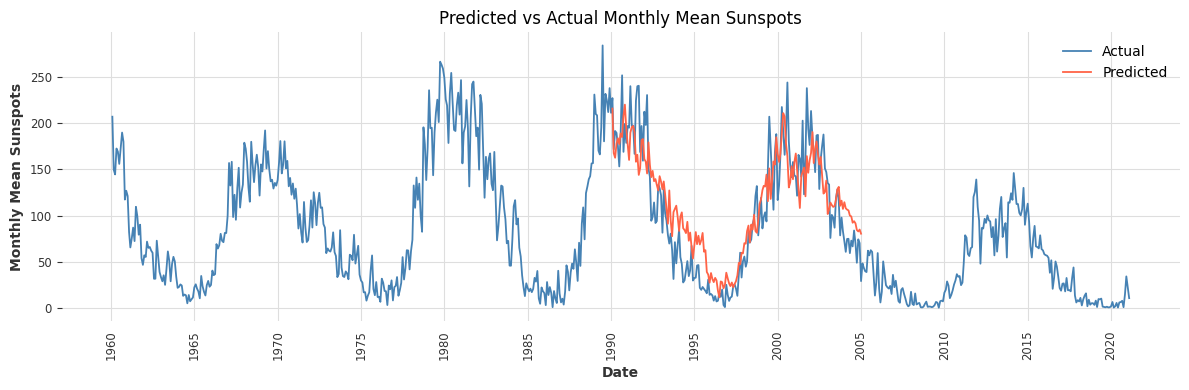

In [214]:
viz_forecast(df_pred_with_optimization)

In [215]:
model_params_with_optimization

{'colsample_bylevel': 0.92,
 'colsample_bynode': 0.82,
 'colsample_bytree': 0.59,
 'gamma': 1.22,
 'learning_rate': 0.21,
 'max_depth': 5,
 'min_child_weight': 2,
 'reg_alpha': 0.28,
 'reg_lambda': 0.07,
 'subsample': 0.56}